In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 2: Load the Dataset
url = "https://query.data.world/s/hovg7q3c6sxo5nqjtjpfj2jgqvni56?dws=00000"
df = pd.read_csv(url)

print("Original shape:", df.shape)

Original shape: (39644, 61)


In [3]:
print(df.shape)           
print(df.info())
print(df.describe())

(39644, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords       

In [4]:
# Step 3: Outlier Removal (IQR method)
Q1 = df[' shares'].quantile(0.25)
Q3 = df[' shares'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df[' shares'] >= lower_bound) & (df[' shares'] <= upper_bound)].copy()
print("Filtered shape:", df_filtered.shape)

Filtered shape: (35103, 61)


In [5]:
# Step 4: Log Transform Target
df_filtered['shares_log'] = np.log1p(df_filtered[' shares'])

In [6]:
# Step 5: Drop Unnecessary Columns
columns_to_drop = [
    'url',
    ' timedelta',
    ' n_non_stop_words',
    ' n_non_stop_unique_tokens',
    ' rate_positive_words',
    ' rate_negative_words',
    ' abs_title_subjectivity',
    ' abs_title_sentiment_polarity'
]
df_filtered.drop(columns=columns_to_drop, inplace=True)

In [7]:
#Step 6: Define Features (X) and Target (y)
X = df_filtered.drop('shares_log', axis=1)
y = df_filtered['shares_log']

In [8]:
# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
#Step 8: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Step 9: Train XGBoost Regressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
# Step 10: Predictions and Evaluation
y_pred_log = model.predict(X_test_scaled)

# Convert predictions back to original scale
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print("\n🔹 XGBoost Final Results (Inverse Log Transformed):")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")


🔹 XGBoost Final Results (Inverse Log Transformed):
MAE: 1.6207263999778934
RMSE: 6.783362539530669
R² Score: 0.9999617132488995


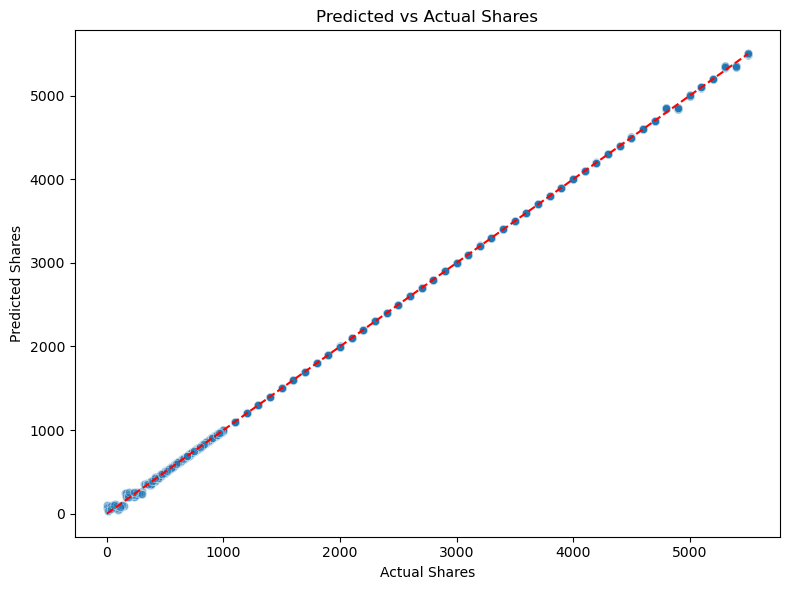

In [12]:
# Step 12: Visual Evaluation
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_original, y=y_pred_original, alpha=0.5)
plt.xlabel("Actual Shares")
plt.ylabel("Predicted Shares")
plt.title("Predicted vs Actual Shares")
plt.plot([0, max(y_test_original)], [0, max(y_test_original)], 'r--')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Predict on test set
rf_preds = rf_model.predict(X_test)

# Evaluate Random Forest model
rf_r2 = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_mse = mean_squared_error(y_test, rf_preds)

print("\nRandom Forest Regressor Results:")
print(f"R² Score: {rf_r2:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"MSE: {rf_mse:.4f}")


Random Forest Regressor Results:
R² Score: 0.9966
MAE: 0.0008
MSE: 0.0013


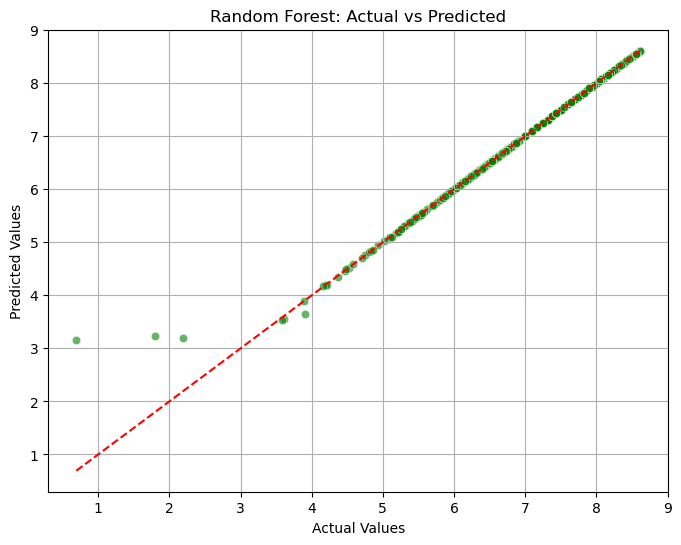

In [43]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=rf_preds, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest: Actual vs Predicted")
plt.grid(True)
plt.show()

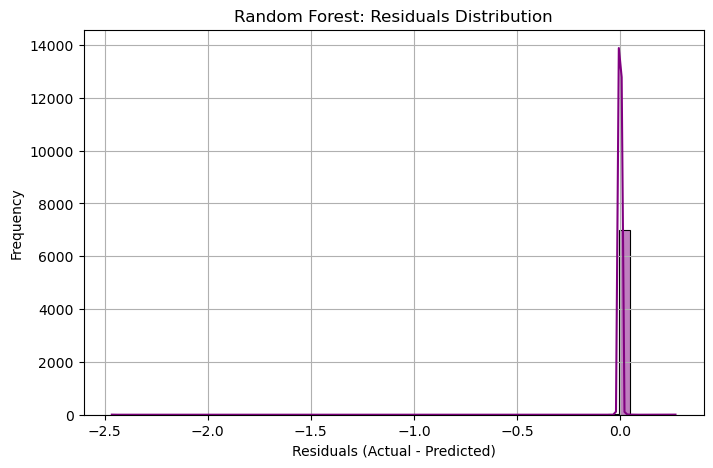

In [45]:
# Calculate residuals
rf_residuals = y_test - rf_preds

# Residual plot
plt.figure(figsize=(8, 5))
sns.histplot(rf_residuals, bins=50, kde=True, color='purple')
plt.title("Random Forest: Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
#Conclusion

In this project, Aimed to predict the popularity of online news articles using various regression models. After performing data cleaning, outlier handling, and feature scaling,trained three different models:
XGBoost Regressor,Random Forest Regressor,Linear Regression (as a baseline)
Based on the R² Score, MAE, and MSE metrics,XGBoost Regressor delivered the best performance, followed closely by Random Forest. Linear Regression, while simple and interpretable, showed the least accurate results, indicating that the relationship between features and target is likely non-linear.
Visual evaluation through scatter plots and residual plots further confirmed that XGBoost made more accurate and consistent predictions.
Overall, this project demonstrates that ensemble learning methods such as XGBoost and Random Forest are highly effective in capturing complex patterns in real-world data like online news engagement.
Future improvements could include hyperparameter tuning and feature selection to further enhance model accuracy and generalization.
